## Nanomole-scale high-throughput chemistry for the synthesis of complex molecules

DOI: 10.1126/science.1259203

Alexander Buitrago Santanilla, Erik L. Regalado, Tony Pereira, Michael Shevlin, Kevin Bateman, Louis-Charles Campeau, Jonathan Schneeweis, Simon Berritt, Zhi-Cai Shi, Philippe Nantermet, Yong Liu, Roy Helmy, Christopher J. Welch, Petr Vachal, Ian W. Davies, Tim Cernak, Spencer D. Dreher *Science* **2015**, *347*, 6217, 49-53. https://www.sciencemag.org/lookup/doi/10.1126/science.1259203

Submission test by Michael R. Maser, Division of Chemistry and Chemical Engineering, California Institute of Technology, Pasadena, CA. mmaser@caltech.edu

Import schema and helper functions

In [1]:
try:
    import ord_schema
    import rdkit
except:
    import sys
    !wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
    !time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
    !time conda install -q -y -c rdkit rdkit
    !time conda install -q -y -c anaconda protobuf
    !git clone https://github.com/Open-Reaction-Database/ord-schema.git
    %cd ord-schema
    !python setup.py install
    sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [2]:
import ord_schema
from datetime import datetime
from ord_schema.proto import dataset_pb2
from ord_schema.proto import reaction_pb2
from ord_schema.units import UnitResolver
from ord_schema import validations
from ord_schema import message_helpers

unit_resolver = UnitResolver()

In [3]:
from tqdm import tqdm

In [4]:
import pandas as pd
import numpy as np
from rdkit import Chem

## Load the dataset
The original dataset published by the authors is found in ./1259203_Datafiles.xlsx, and the "Data S2- Experiment 2" page was converted to .csv in ./experiment_2.csv

In [5]:
# Create pandas dataframe
data = pd.read_csv('experiment_2.csv')

# View dataframe
data

,Plate Position,Electrophile,Electrophile charge,Nucleophile,Nucleophile charge,Catalyst,Catalyst charge,Base,Base charge,IS,ArBr,Prod,Nu,Pd/IS,Unnamed: 14
0,A1,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),DBU 24,250 nL (200 nmol),240134.0,1206548.0,0.0,2638835.0,0.00,NaN
1,A2,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),238726.0,1130276.0,0.0,2474074.0,0.00,NaN
2,A3,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),235018.0,1099909.0,0.0,2387052.0,0.00,NaN
3,A4,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),238060.0,1111019.0,32684.0,2511884.0,0.14,NaN
4,A5,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),232567.0,1116529.0,0.0,2576513.0,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533,AF46,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),202191.0,815521.0,453729.0,NaN,2.24,NaN
1534,AF47,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),201368.0,622883.0,1109048.0,NaN,5.51,NaN
1535,AF48,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),P2Et 29,250 nL (200 nmol),197245.0,515647.0,468247.0,NaN,2.37,NaN
1536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Remove unnecessary rows and columns
data = data.drop(['Unnamed: 14'], axis=1)
data.drop(data.tail(2).index, inplace=True)

# View new dataframe
data

,Plate Position,Electrophile,Electrophile charge,Nucleophile,Nucleophile charge,Catalyst,Catalyst charge,Base,Base charge,IS,ArBr,Prod,Nu,Pd/IS
0,A1,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),DBU 24,250 nL (200 nmol),240134.0,1206548.0,0.0,2638835.0,0.00
1,A2,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),238726.0,1130276.0,0.0,2474074.0,0.00
2,A3,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),235018.0,1099909.0,0.0,2387052.0,0.00
3,A4,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),238060.0,1111019.0,32684.0,2511884.0,0.14
4,A5,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),232567.0,1116529.0,0.0,2576513.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,AF44,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),178234.0,0.0,3046576.0,NaN,17.09
1532,AF45,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),229584.0,254050.0,2789535.0,NaN,12.15
1533,AF46,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),202191.0,815521.0,453729.0,NaN,2.24
1534,AF47,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),201368.0,622883.0,1109048.0,NaN,5.51


## Identify and replace coded reaction components

In [7]:
# Extract unique values for each reaction component
reagent_dict = {}
component_types = ['Electrophile', 'Nucleophile', 'Catalyst', 'Base']

# Create dictionary for each component set with names and SMILES
for component in component_types:
    component_dict = {}
    for i, unique in enumerate(list(data[component].unique())):
        component_dict[f'{component}_{i}'] = {'name': unique, 
                                              'SMILES': 'placeholder'}
    reagent_dict[f'{component}s'] = component_dict    

# Check length of each list 
for reagent, uniques in reagent_dict.items():
    print(f'{reagent} count: {len(uniques)}')

reagent_dict

Electrophiles count: 1
Nucleophiles count: 16
Catalysts count: 16
Bases count: 6


{'Electrophiles': {'Electrophile_0': {'name': 'bromide 22',
   'SMILES': 'placeholder'}},
 'Nucleophiles': {'Nucleophile_0': {'name': 'amine S1',
   'SMILES': 'placeholder'},
  'Nucleophile_1': {'name': 'aniline S2', 'SMILES': 'placeholder'},
  'Nucleophile_2': {'name': 'amide S4', 'SMILES': 'placeholder'},
  'Nucleophile_3': {'name': 'sulfonamide S5', 'SMILES': 'placeholder'},
  'Nucleophile_4': {'name': 'aminopyridine S3', 'SMILES': 'placeholder'},
  'Nucleophile_5': {'name': 'amidine S6', 'SMILES': 'placeholder'},
  'Nucleophile_6': {'name': 'tBu carbamate S7', 'SMILES': 'placeholder'},
  'Nucleophile_7': {'name': 'indazole S8', 'SMILES': 'placeholder'},
  'Nucleophile_8': {'name': 'alcohol S9', 'SMILES': 'placeholder'},
  'Nucleophile_9': {'name': 'phenol S10', 'SMILES': 'placeholder'},
  'Nucleophile_10': {'name': 'thiophenol S11', 'SMILES': 'placeholder'},
  'Nucleophile_11': {'name': 'phosphine S12', 'SMILES': 'placeholder'},
  'Nucleophile_12': {'name': 'boronate S14/water', 'S

In [8]:
# Add product identifier (dependent on nucleophile)
# Create nucleophile to product mapping
product_dict = {}
reagent_dict['Products'] = {}
for i, nucleophile in enumerate(reagent_dict['Nucleophiles'].keys()):
    nucleophile_name = reagent_dict['Nucleophiles'][nucleophile]['name']
    product_name = f'Product_{i}'
    product_dict[nucleophile_name] = product_name
    
    # Add products to reagent_dict
    reagent_dict['Products'][f'Product_{i}'] = {'name': product_name,
                                                'SMILES': 'placeholder'}

# Add product column to dataframe using map
data['Product'] = data['Nucleophile'].map(product_dict)

# Add reaction type identifier (dependent on nucleophile)
reaction_type_dict = {
    'amine S1': 'Buchwald-Hartwig amination',
    'aniline S2': 'Buchwald-Hartwig amination',
    'amide S4': 'Buchwald-Hartwig amination',
    'sulfonamide S5': 'Buchwald-Hartwig amination',
    'aminopyridine S3': 'Buchwald-Hartwig amination',
    'amidine S6': 'Buchwald-Hartwig amination',
    'tBu carbamate S7': 'Buchwald-Hartwig amination',
    'indazole S8': 'Buchwald-Hartwig amination',
    'alcohol S9': 'Buchwald-Hartwig etherification',
    'phenol S10': 'Buchwald-Hartwig etherification',
    'thiophenol S11': 'Buchwald-Hartwig thioetherification',
    'phosphine S12': 'Buchwald-Hartwig phosphination',
    'boronate S14/water': 'Suzuki-Miyaura coupling',
    'malonate S13': 'Pd-catalyzed enolate arylation',
    'alkene S15': 'Heck coupling',
    'alkyne S16': 'Sonogashira coupling',
}

# Add reaction type column to dataframe using map
data['Reaction_type'] = data['Nucleophile'].map(reaction_type_dict)

# View changes
data

,Plate Position,Electrophile,Electrophile charge,Nucleophile,Nucleophile charge,Catalyst,Catalyst charge,Base,Base charge,IS,ArBr,Prod,Nu,Pd/IS,Product,Reaction_type
0,A1,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),DBU 24,250 nL (200 nmol),240134.0,1206548.0,0.0,2638835.0,0.00,Product_0,Buchwald-Hartwig amination
1,A2,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),238726.0,1130276.0,0.0,2474074.0,0.00,Product_0,Buchwald-Hartwig amination
2,A3,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),235018.0,1099909.0,0.0,2387052.0,0.00,Product_0,Buchwald-Hartwig amination
3,A4,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),238060.0,1111019.0,32684.0,2511884.0,0.14,Product_0,Buchwald-Hartwig amination
4,A5,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),232567.0,1116529.0,0.0,2576513.0,0.00,Product_0,Buchwald-Hartwig amination
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,AF44,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),178234.0,0.0,3046576.0,NaN,17.09,Product_15,Sonogashira coupling
1532,AF45,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),229584.0,254050.0,2789535.0,NaN,12.15,Product_15,Sonogashira coupling
1533,AF46,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),202191.0,815521.0,453729.0,NaN,2.24,Product_15,Sonogashira coupling
1534,AF47,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),201368.0,622883.0,1109048.0,NaN,5.51,Product_15,Sonogashira coupling


In [9]:
# See updated reagent_dict
reagent_dict

{'Electrophiles': {'Electrophile_0': {'name': 'bromide 22',
   'SMILES': 'placeholder'}},
 'Nucleophiles': {'Nucleophile_0': {'name': 'amine S1',
   'SMILES': 'placeholder'},
  'Nucleophile_1': {'name': 'aniline S2', 'SMILES': 'placeholder'},
  'Nucleophile_2': {'name': 'amide S4', 'SMILES': 'placeholder'},
  'Nucleophile_3': {'name': 'sulfonamide S5', 'SMILES': 'placeholder'},
  'Nucleophile_4': {'name': 'aminopyridine S3', 'SMILES': 'placeholder'},
  'Nucleophile_5': {'name': 'amidine S6', 'SMILES': 'placeholder'},
  'Nucleophile_6': {'name': 'tBu carbamate S7', 'SMILES': 'placeholder'},
  'Nucleophile_7': {'name': 'indazole S8', 'SMILES': 'placeholder'},
  'Nucleophile_8': {'name': 'alcohol S9', 'SMILES': 'placeholder'},
  'Nucleophile_9': {'name': 'phenol S10', 'SMILES': 'placeholder'},
  'Nucleophile_10': {'name': 'thiophenol S11', 'SMILES': 'placeholder'},
  'Nucleophile_11': {'name': 'phosphine S12', 'SMILES': 'placeholder'},
  'Nucleophile_12': {'name': 'boronate S14/water', 'S

## Add SMILES representations for dataset molecules

### SMILES testing for metal complexes
RDKit SMILES parsing fails for ChemDraw-generated SMILES of plainly drawn metal complexes due to valence rules on N atoms. Using dative bonds in ChemDraw fixes this problem, though ChemDraw's syntax for ferrocene complexes leads to RDKit parsing failures. PubChem "canonical" SMILES for metal complexes treats each substructure as a separate component (e.g., metals, ligands, ions), leading to a salt-like representation of the compounds. Ultimately found that using ChemDraw to generate SMILES with dative bonds to ligands and ferrocenes drawn explicitly as cyclopentadienyl-anion-sandwiched Fe atoms led to the most reasonable representations. Some examples are provided below; if anyone has a better solution for this, I'd be happy to make changes. <br><br>
See the discussion here for the shortcomings of SMILES in representing metallocenes: https://chemistry.stackexchange.com/questions/20486/what-would-be-smiles-notation-for-a-compound-with-delocalized-bonding <br><br>
Structures are drawn in ./Santanilla_component_smiles.cdx and Chemdraw generated SMILES (non-canonical) are copied to ./experiment_2_molecules.csv

CS(=O)(=O)O.Nc1ccccc1-c1[c-]cccc1.[CH]1[CH][CH][C](P(c2ccccc2)c2ccccc2)[CH]1.[CH]1[CH][CH][C](P(c2ccccc2)c2ccccc2)[CH]1.[Fe].[Pd]


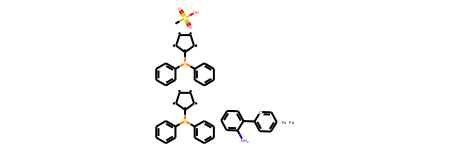

In [10]:
# Testing PubChem SMILES for ferrocene complexes
# Create RDKit mol object from DPPF Pd G3 PubChem SMILES
dppf_pd_g3_pubchem = Chem.MolFromSmiles('CS(=O)(=O)O.C1=CC=C(C=C1)P(C2=CC=CC=C2)[C]3[CH][CH][CH][CH]3.C1=CC=C(C=C1)P(C2=CC=CC=C2)[C]3[CH][CH][CH][CH]3.C1=CC=C([C-]=C1)C2=CC=CC=C2N.[Fe].[Pd]')

# Get RDKit canonicalized SMILES
dppf_pd_g3_pubchem_can = Chem.MolToSmiles(dppf_pd_g3_pubchem)

# Show RDKit canonicalized SMILES and render molecule
# Result shows a collection of fragment structures
print(dppf_pd_g3_pubchem_can)
dppf_pd_g3_pubchem

CS(=O)(=O)O[Pd-2]1([P+](C2=CC=CC2[Fe]C2C=CC=C2P(c2ccccc2)c2ccccc2)(c2ccccc2)c2ccccc2)[NH2+]c2ccccc2-c2ccccc21


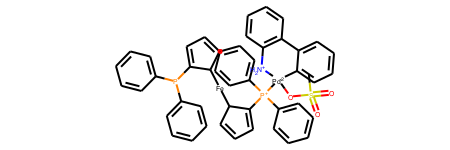

In [11]:
# Testing ChemDraw generated SMILES for drawn ferrocene complexes
# using dative bonds and cyclopentadienyl-anion-sandwiched Fe atoms
# Create RDKit mol object from DPPF Pd G3 ChemDraw SMILES
dppf_pd_g3 = Chem.MolFromSmiles('CS(O[Pd-2]1([P+](C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC4[Fe]C5C(P(C6=CC=CC=C6)C7=CC=CC=C7)=CC=C5)C8=CC=CC=C8C9=C([NH2+]1)C=CC=C9)(=O)=O')

# Get RDKit canonicalized SMILES
dppf_pd_g3_can = Chem.MolToSmiles(dppf_pd_g3)

# Show RDKit canonicalized SMILES and render molecule
# Result is still not a reasonable representation of ferrocene bonding,
# but it at least gives a bound representation of the whole complex
print(dppf_pd_g3_can)
dppf_pd_g3

### Add SMILES to dataset
SMILES are imported in non-canonical format as generated by ChemDraw. SMILES are canonicalized by RDKit below before including in dataset

In [12]:
# Load SMILES info from Chemdraw .csv
smiles_data = pd.read_csv('experiment_2_molecules.csv')
smiles_data

,component_name,dataset_name,non_canonical_smiles
0,Electrophile_0,bromide 22,BrC1=CN=CC=C1
1,Nucleophile_0,amine S1,CC(N)CCC1=CC=CC=C1
2,Nucleophile_1,aniline S2,NC1=CC=CC=C1
3,Nucleophile_2,amide S4,NC(C1=CC=CC=C1)=O
4,Nucleophile_3,sulfonamide S5,NS(C1=CC=CC=C1)(=O)=O
5,Nucleophile_4,aminopyridine S3,NC1=NC=C(C2=CC=CC=C2)C=C1
6,Nucleophile_5,amidine S6,NC(CC1=CC=CC=C1)=N
7,Nucleophile_6,tBu carbamate S7,NC(OC(C)(C)C)=O
8,Nucleophile_7,indazole S8,C12=CC=CC=C1NN=C2
9,Nucleophile_8,alcohol S9,OCCCC1=CC=CC=C1


In [13]:
# Canonicalize component SMILES
canonical_smiles = []
for smiles in smiles_data['non_canonical_smiles']:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if not mol == None:
            can_smiles = Chem.MolToSmiles(mol)
            canonical_smiles.append(can_smiles)
        else:
            raise Exception(f'Error, unable to canonicalize the following smiles: {smiles}, non-canonical smiles added to final list instead')
            canonical_smiles.append(smiles)
    except:
        raise Exception(f'Error, unable to canonicalize the following smiles: {smiles}, non-canonical smiles added to final list instead')
        canonical_smiles.append(smiles)

# Add canonical SMILES to SMILES dataframe
smiles_data['canonical_smiles'] = canonical_smiles

# View new SMILES dataframe
smiles_data

,component_name,dataset_name,non_canonical_smiles,canonical_smiles
0,Electrophile_0,bromide 22,BrC1=CN=CC=C1,Brc1cccnc1
1,Nucleophile_0,amine S1,CC(N)CCC1=CC=CC=C1,CC(N)CCc1ccccc1
2,Nucleophile_1,aniline S2,NC1=CC=CC=C1,Nc1ccccc1
3,Nucleophile_2,amide S4,NC(C1=CC=CC=C1)=O,NC(=O)c1ccccc1
4,Nucleophile_3,sulfonamide S5,NS(C1=CC=CC=C1)(=O)=O,NS(=O)(=O)c1ccccc1
5,Nucleophile_4,aminopyridine S3,NC1=NC=C(C2=CC=CC=C2)C=C1,Nc1ccc(-c2ccccc2)cn1
6,Nucleophile_5,amidine S6,NC(CC1=CC=CC=C1)=N,N=C(N)Cc1ccccc1
7,Nucleophile_6,tBu carbamate S7,NC(OC(C)(C)C)=O,CC(C)(C)OC(N)=O
8,Nucleophile_7,indazole S8,C12=CC=CC=C1NN=C2,c1ccc2[nH]ncc2c1
9,Nucleophile_8,alcohol S9,OCCCC1=CC=CC=C1,OCCCc1ccccc1


## Add canonicalized SMILES to reagent_dict and create compound to SMILES mapping

In [14]:
# View current dictionary
reagent_dict

{'Electrophiles': {'Electrophile_0': {'name': 'bromide 22',
   'SMILES': 'placeholder'}},
 'Nucleophiles': {'Nucleophile_0': {'name': 'amine S1',
   'SMILES': 'placeholder'},
  'Nucleophile_1': {'name': 'aniline S2', 'SMILES': 'placeholder'},
  'Nucleophile_2': {'name': 'amide S4', 'SMILES': 'placeholder'},
  'Nucleophile_3': {'name': 'sulfonamide S5', 'SMILES': 'placeholder'},
  'Nucleophile_4': {'name': 'aminopyridine S3', 'SMILES': 'placeholder'},
  'Nucleophile_5': {'name': 'amidine S6', 'SMILES': 'placeholder'},
  'Nucleophile_6': {'name': 'tBu carbamate S7', 'SMILES': 'placeholder'},
  'Nucleophile_7': {'name': 'indazole S8', 'SMILES': 'placeholder'},
  'Nucleophile_8': {'name': 'alcohol S9', 'SMILES': 'placeholder'},
  'Nucleophile_9': {'name': 'phenol S10', 'SMILES': 'placeholder'},
  'Nucleophile_10': {'name': 'thiophenol S11', 'SMILES': 'placeholder'},
  'Nucleophile_11': {'name': 'phosphine S12', 'SMILES': 'placeholder'},
  'Nucleophile_12': {'name': 'boronate S14/water', 'S

In [15]:
# Fill in placeholder SMILES in reagent_dict with canonical SMILES
# and create mapping from dataset name to canonical SMILES
smiles_map = {}
for subclass, components in reagent_dict.items():
    for component, details in components.items():
        details['SMILES'] = smiles_data.loc[smiles_data['component_name'] == component, 'canonical_smiles'].values[0]
        smiles_map[details['name']] = details['SMILES']

# View completed dictionary
reagent_dict

{'Electrophiles': {'Electrophile_0': {'name': 'bromide 22',
   'SMILES': 'Brc1cccnc1'}},
 'Nucleophiles': {'Nucleophile_0': {'name': 'amine S1',
   'SMILES': 'CC(N)CCc1ccccc1'},
  'Nucleophile_1': {'name': 'aniline S2', 'SMILES': 'Nc1ccccc1'},
  'Nucleophile_2': {'name': 'amide S4', 'SMILES': 'NC(=O)c1ccccc1'},
  'Nucleophile_3': {'name': 'sulfonamide S5', 'SMILES': 'NS(=O)(=O)c1ccccc1'},
  'Nucleophile_4': {'name': 'aminopyridine S3',
   'SMILES': 'Nc1ccc(-c2ccccc2)cn1'},
  'Nucleophile_5': {'name': 'amidine S6', 'SMILES': 'N=C(N)Cc1ccccc1'},
  'Nucleophile_6': {'name': 'tBu carbamate S7', 'SMILES': 'CC(C)(C)OC(N)=O'},
  'Nucleophile_7': {'name': 'indazole S8', 'SMILES': 'c1ccc2[nH]ncc2c1'},
  'Nucleophile_8': {'name': 'alcohol S9', 'SMILES': 'OCCCc1ccccc1'},
  'Nucleophile_9': {'name': 'phenol S10', 'SMILES': 'Oc1ccccc1'},
  'Nucleophile_10': {'name': 'thiophenol S11', 'SMILES': 'Sc1ccccc1'},
  'Nucleophile_11': {'name': 'phosphine S12', 'SMILES': 'c1ccc(Pc2ccccc2)cc1'},
  'Nucleophi

In [16]:
# View SMILES mapping
smiles_map

{'bromide 22': 'Brc1cccnc1',
 'amine S1': 'CC(N)CCc1ccccc1',
 'aniline S2': 'Nc1ccccc1',
 'amide S4': 'NC(=O)c1ccccc1',
 'sulfonamide S5': 'NS(=O)(=O)c1ccccc1',
 'aminopyridine S3': 'Nc1ccc(-c2ccccc2)cn1',
 'amidine S6': 'N=C(N)Cc1ccccc1',
 'tBu carbamate S7': 'CC(C)(C)OC(N)=O',
 'indazole S8': 'c1ccc2[nH]ncc2c1',
 'alcohol S9': 'OCCCc1ccccc1',
 'phenol S10': 'Oc1ccccc1',
 'thiophenol S11': 'Sc1ccccc1',
 'phosphine S12': 'c1ccc(Pc2ccccc2)cc1',
 'boronate S14/water': 'CC1(C)OB(c2cnn(Cc3ccccc3)c2)OC1(C)C',
 'malonate S13': 'CCOC(=O)CC(=O)OCC',
 'alkene S15': 'CCOC(=O)/C=C/c1ccccc1',
 'alkyne S16': 'C#Cc1ccc(CCCC)cc1',
 'BINAP Pd G3 30': 'CS(=O)(=O)O[Pd-2]1([P+](c2ccccc2)(c2ccccc2)c2ccc3ccccc3c2-c2c(P(c3ccccc3)c3ccccc3)ccc3ccccc23)[NH2+]c2ccccc2-c2ccccc21',
 'DPPF Pd G3 31': 'CS(=O)(=O)O[Pd-2]1([P+](C2=CC=CC2[Fe]C2C=CC=C2P(c2ccccc2)c2ccccc2)(c2ccccc2)c2ccccc2)[NH2+]c2ccccc2-c2ccccc21',
 'XantPhos Pd G2 32': 'CC1(C)c2cccc(P(c3ccccc3)c3ccccc3)c2Oc2c1cccc2[P+](c1ccccc1)(c1ccccc1)[Pd-2]1(Cl)[

## Add component SMILES and yield columns to data

In [17]:
# Make list of columns to be mapped to corresponding SMILES
subclasses = ['Electrophile', 'Nucleophile', 'Catalyst', 'Base', 'Product']

# Create new columns using smiles_map
for subclass in subclasses:
    data[f'{subclass}_SMILES'] = data[subclass].map(smiles_map)

# View changes
data

,Plate Position,Electrophile,Electrophile charge,Nucleophile,Nucleophile charge,Catalyst,Catalyst charge,Base,Base charge,IS,...,Prod,Nu,Pd/IS,Product,Reaction_type,Electrophile_SMILES,Nucleophile_SMILES,Catalyst_SMILES,Base_SMILES,Product_SMILES
0,A1,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),DBU 24,250 nL (200 nmol),240134.0,...,0.0,2638835.0,0.00,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd-2]1([P+](c2ccccc2)(c2ccccc2)c2c...,C1CCC2=NCCCN2CC1,CC(CCc1ccccc1)Nc1cccnc1
1,A2,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),238726.0,...,0.0,2474074.0,0.00,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd-2]1([P+](c2ccccc2)(c2ccccc2)c2c...,CN1CCCN2CCCN=C12,CC(CCc1ccccc1)Nc1cccnc1
2,A3,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),235018.0,...,0.0,2387052.0,0.00,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd-2]1([P+](c2ccccc2)(c2ccccc2)c2c...,CN(C)C(=NC(C)(C)C)N(C)C,CC(CCc1ccccc1)Nc1cccnc1
3,A4,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),238060.0,...,32684.0,2511884.0,0.14,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd-2]1([P+](c2ccccc2)(c2ccccc2)c2c...,CCN(CC)P1(=NC(C)(C)C)N(C)CCCN1C,CC(CCc1ccccc1)Nc1cccnc1
4,A5,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),232567.0,...,0.0,2576513.0,0.00,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd-2]1([P+](c2ccccc2)(c2ccccc2)c2c...,CC(C)(C)N=P(N1CCCC1)(N1CCCC1)N1CCCC1,CC(CCc1ccccc1)Nc1cccnc1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,AF44,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),178234.0,...,3046576.0,NaN,17.09,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COc1ccc(OC)c([P+](C23C[C@H]4C[C@@H](C2)C[C@@H]...,CN1CCCN2CCCN=C12,CCCCc1ccc(C#Cc2cccnc2)cc1
1532,AF45,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),229584.0,...,2789535.0,NaN,12.15,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COc1ccc(OC)c([P+](C23C[C@H]4C[C@@H](C2)C[C@@H]...,CN(C)C(=NC(C)(C)C)N(C)C,CCCCc1ccc(C#Cc2cccnc2)cc1
1533,AF46,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),202191.0,...,453729.0,NaN,2.24,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COc1ccc(OC)c([P+](C23C[C@H]4C[C@@H](C2)C[C@@H]...,CCN(CC)P1(=NC(C)(C)C)N(C)CCCN1C,CCCCc1ccc(C#Cc2cccnc2)cc1
1534,AF47,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),201368.0,...,1109048.0,NaN,5.51,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COc1ccc(OC)c([P+](C23C[C@H]4C[C@@H](C2)C[C@@H]...,CC(C)(C)N=P(N1CCCC1)(N1CCCC1)N1CCCC1,CCCCc1ccc(C#Cc2cccnc2)cc1


In [18]:
# Check yield distributions
data.describe()

,IS,ArBr,Prod,Nu,Pd/IS
count,1.536000e+03,1.536000e+03,1.536000e+03,6.720000e+02,1531.000000
mean,2.387198e+05,8.901066e+05,4.282438e+05,2.058694e+06,2.057387
std,1.145788e+05,3.836603e+05,9.515332e+05,7.573593e+05,4.755118
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,1.931702e+05,7.479282e+05,0.000000e+00,1.623829e+06,0.000000
50%,2.191730e+05,1.023685e+06,0.000000e+00,2.175684e+06,0.000000
75%,2.396105e+05,1.126468e+06,2.587668e+05,2.597350e+06,1.160000
max,1.274687e+06,2.181530e+06,6.411983e+06,5.094171e+06,39.810000


In [19]:
# Above table indicates there are missing values; find where
# Below table indicates 'Nu' and 'Pd/IS' absorption measurments are missing
# from many reactions
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1536 entries, 0 to 1535
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Plate Position       1536 non-null   object 
 1   Electrophile         1536 non-null   object 
 2   Electrophile charge  1536 non-null   object 
 3   Nucleophile          1536 non-null   object 
 4   Nucleophile charge   1536 non-null   object 
 5   Catalyst             1536 non-null   object 
 6   Catalyst charge      1536 non-null   object 
 7   Base                 1536 non-null   object 
 8   Base charge          1536 non-null   object 
 9   IS                   1536 non-null   float64
 10  ArBr                 1536 non-null   float64
 11  Prod                 1536 non-null   float64
 12  Nu                   672 non-null    float64
 13  Pd/IS                1531 non-null   float64
 14  Product              1536 non-null   object 
 15  Reaction_type        1536 non-null   o

In [20]:
# Going to assume missing values are undetected, i.e., 0 absorbtion
# Fill in missing values with 0 for 'IS', 'ArBr', 'Prod', 'Nu', 'Pd/IS'
for column in ['IS', 'ArBr', 'Prod', 'Nu', 'Pd/IS']:
    data[column] = data[column].fillna(0)

# Add explicit yield columns, dividing 'IS' by .03 as procedure claims
# final IS loading is 3 mol % relative to ArBr. Paper uses Pd/IS to directly
# compare performance of each reaction conditions, but is not actually a
# reaction yield measurement
data['Product_yield'] = round(((data['Prod']/(data['IS']/0.03))*100), 2)
data['ArBr_yield'] = round(((data['ArBr']/(data['IS']/0.03))*100), 2)
data['Nu_yield'] = round(((data['Nu']/(data['IS']/0.03))*100), 2)

# Handle any cases where 'IS' = 0 and 0 division failed
# Reset any yields greater than 105% (ORD limit)
for column in ['Product_yield', 'ArBr_yield', 'Nu_yield']:
    data[column] = data[column].fillna(0)
    data.loc[data[column] > 105, column] = 105

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1536 entries, 0 to 1535
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Plate Position       1536 non-null   object 
 1   Electrophile         1536 non-null   object 
 2   Electrophile charge  1536 non-null   object 
 3   Nucleophile          1536 non-null   object 
 4   Nucleophile charge   1536 non-null   object 
 5   Catalyst             1536 non-null   object 
 6   Catalyst charge      1536 non-null   object 
 7   Base                 1536 non-null   object 
 8   Base charge          1536 non-null   object 
 9   IS                   1536 non-null   float64
 10  ArBr                 1536 non-null   float64
 11  Prod                 1536 non-null   float64
 12  Nu                   1536 non-null   float64
 13  Pd/IS                1536 non-null   float64
 14  Product              1536 non-null   object 
 15  Reaction_type        1536 non-null   o

In [21]:
# View final dataset
data

,Plate Position,Electrophile,Electrophile charge,Nucleophile,Nucleophile charge,Catalyst,Catalyst charge,Base,Base charge,IS,...,Product,Reaction_type,Electrophile_SMILES,Nucleophile_SMILES,Catalyst_SMILES,Base_SMILES,Product_SMILES,Product_yield,ArBr_yield,Nu_yield
0,A1,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),DBU 24,250 nL (200 nmol),240134.0,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd-2]1([P+](c2ccccc2)(c2ccccc2)c2c...,C1CCC2=NCCCN2CC1,CC(CCc1ccccc1)Nc1cccnc1,0.00,15.07,32.97
1,A2,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),238726.0,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd-2]1([P+](c2ccccc2)(c2ccccc2)c2c...,CN1CCCN2CCCN=C12,CC(CCc1ccccc1)Nc1cccnc1,0.00,14.20,31.09
2,A3,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),235018.0,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd-2]1([P+](c2ccccc2)(c2ccccc2)c2c...,CN(C)C(=NC(C)(C)C)N(C)C,CC(CCc1ccccc1)Nc1cccnc1,0.00,14.04,30.47
3,A4,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),238060.0,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd-2]1([P+](c2ccccc2)(c2ccccc2)c2c...,CCN(CC)P1(=NC(C)(C)C)N(C)CCCN1C,CC(CCc1ccccc1)Nc1cccnc1,0.41,14.00,31.65
4,A5,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),232567.0,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd-2]1([P+](c2ccccc2)(c2ccccc2)c2c...,CC(C)(C)N=P(N1CCCC1)(N1CCCC1)N1CCCC1,CC(CCc1ccccc1)Nc1cccnc1,0.00,14.40,33.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,AF44,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),178234.0,...,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COc1ccc(OC)c([P+](C23C[C@H]4C[C@@H](C2)C[C@@H]...,CN1CCCN2CCCN=C12,CCCCc1ccc(C#Cc2cccnc2)cc1,51.28,0.00,0.00
1532,AF45,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),229584.0,...,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COc1ccc(OC)c([P+](C23C[C@H]4C[C@@H](C2)C[C@@H]...,CN(C)C(=NC(C)(C)C)N(C)C,CCCCc1ccc(C#Cc2cccnc2)cc1,36.45,3.32,0.00
1533,AF46,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),202191.0,...,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COc1ccc(OC)c([P+](C23C[C@H]4C[C@@H](C2)C[C@@H]...,CCN(CC)P1(=NC(C)(C)C)N(C)CCCN1C,CCCCc1ccc(C#Cc2cccnc2)cc1,6.73,12.10,0.00
1534,AF47,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),201368.0,...,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COc1ccc(OC)c([P+](C23C[C@H]4C[C@@H](C2)C[C@@H]...,CC(C)(C)N=P(N1CCCC1)(N1CCCC1)N1CCCC1,CCCCc1ccc(C#Cc2cccnc2)cc1,16.52,9.28,0.00


In [22]:
# Show final dataset statistics
data.describe()

,IS,ArBr,Prod,Nu,Pd/IS,Product_yield,ArBr_yield,Nu_yield
count,1.536000e+03,1.536000e+03,1.536000e+03,1.536000e+03,1536.000000,1536.000000,1536.000000,1536.000000
mean,2.387198e+05,8.901066e+05,4.282438e+05,9.006787e+05,2.050690,6.142637,12.522415,10.991693
std,1.145788e+05,3.836603e+05,9.515332e+05,1.137724e+06,4.748815,14.176408,7.543527,14.342441
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.931702e+05,7.479282e+05,0.000000e+00,0.000000e+00,0.000000,0.000000,8.247500,0.000000
50%,2.191730e+05,1.023685e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,13.560000,0.000000
75%,2.396105e+05,1.126468e+06,2.587668e+05,2.093107e+06,1.127500,3.392500,16.390000,25.692500
max,1.274687e+06,2.181530e+06,6.411983e+06,5.094171e+06,39.810000,105.000000,92.860000,86.120000


# Define a single reaction

This experiment details the screening of cross-coupling reactions between one aryl halide with 16 nucleophiles using 16 different precatalysts and 6 bases (1536 reactions)

The general procedure from the SI is as follows:

"**Experiment 2. 1536-Well Plate Screening of Pd Cross-Coupling Reactions of 3- Bromopyridine 22 with 16 Nucleophiles (16 Precatalysts, 6 Bases)**

A 1536-well plate experiment examining the reactivity of 3-bromopyridine 22 with 16 different classes of nucleophiles under 96 Pd cross-coupling reaction conditions was run at 100 nanomolar scale by dosing from a 384-well plate containing stock solutions of the starting materials and reagents into a 1536-Well Plate by Mosquito.<br>

**Procedure.** Stock solutions of each of the reaction components were prepared as follows: Pd- precatalysts (**30-45**, 0.04 M in DMSO), aryl halide (**22**, 0.4 M in DMSO), nucleophiles (**S1-S16**, 0.6 M in DMSO), and base (**24-29**, 0.8 M in DMSO). Each of the solutions was dispensed in 75 uL charges to a 384-well plate (source plate map is shown in Figure S8, components listed in Table S2).<br>

The Mosquito was used to combine the source plate solutions by multi-aspiration of 250 nL of each of the four reaction components and then to dose the resulting reaction mixture (1 uL) into a 1536-well plate. Once the 1536-well plate was fully dosed the plate was covered by a PFA film and clamped to minimize low-level component volatility. The plate was then allowed to sit at room temperature for 22 hours. Using the Mosquito, the plate was then quenched with 3 uL of a DMSO stock solution of acetic 5% acid and biphenyl (to give 3 mol% biphenyl relative to **22**), which was transferred from a 384-well source plate. The Mosquito then sampled 1 uL from the quenched reaction plate into 4 x 384-well plates containing 75 uL of DMSO per well. The Mosquito mixing feature was used three times per aspiration and dispense steps in order to ensure homogeneity of the analytical sample. The 384-well plate was then heat-sealed and subjected to chromatographic analysis by a Waters UPLC Instrument. The ratio of the LC area counts of product over internal standard was used to directly compare the relative performance of these reactions."

In [23]:
# Calculate stoichiometry
# List component stock solution concentrations (in M or nmol/nL) 
electrophile_stock_conc = 0.4
nucleophile_stock_conc = 0.6
base_stock_conc = 0.8
catalyst_stock_conc = 0.04

# Calculate nmol of each component added
electrophile_nmol = electrophile_stock_conc * 250
nucleophile_nmol = nucleophile_stock_conc * 250
base_nmol = base_stock_conc * 250
catalyst_nmol = catalyst_stock_conc * 250

# Show values
print(electrophile_nmol, nucleophile_nmol, base_nmol, catalyst_nmol)

100.0 150.0 200.0 10.0


### Set up reaction in flow of Reaction message
1. Define reaction
2. Add identifiers
3. Add inputs
4. Describe setup
5. Describe conditions
6. Add notes
7. Add observations
8. Describe workup
9. Describe outcomes
10. Add provenance

#### 1. Define reaction

In [24]:
# Initialize Reaction
reaction = reaction_pb2.Reaction()

#### 2. Add identifiers

In [25]:
reaction.identifiers.add(value=r'placeholder', type='NAME')

type: NAME
value: "placeholder"

#### 3. Add inputs

In [26]:
# Reactant 1
reaction.inputs['reactant_1'].addition_order = 1
solute = reaction.inputs['reactant_1'].components.add()
solvent = reaction.inputs['reactant_1'].components.add()
solute.CopyFrom(message_helpers.build_compound(
    name='placeholder', smiles='placeholder', role='reactant',
    amount='100 nmol', prep=None, is_limiting=True,
    prep_details=None,
))
solvent.CopyFrom(message_helpers.build_compound(
    name='DMSO', smiles='CS(C)=O', role='solvent',
    amount='0.25 uL', prep=None, is_limiting=False,
    prep_details=None,
))
solvent.volume_includes_solutes = True

# Reactant 2
reaction.inputs['reactant_2'].addition_order = 1
solute = reaction.inputs['reactant_2'].components.add()
solvent = reaction.inputs['reactant_2'].components.add()
solute.CopyFrom(message_helpers.build_compound(
    name='placeholder', smiles='placeholder', role='reactant',
    amount='150 nmol', prep=None, is_limiting=False,
    prep_details=None,
))
solvent.CopyFrom(message_helpers.build_compound(
    name='DMSO', smiles='CS(C)=O', role='solvent',
    amount='0.25 uL', prep=None, is_limiting=False,
    prep_details=None,
))
solvent.volume_includes_solutes = True

# Reagent 1 = Base
reaction.inputs['base'].addition_order = 1
solute = reaction.inputs['base'].components.add()
solvent = reaction.inputs['base'].components.add()
solute.CopyFrom(message_helpers.build_compound(
    name='placeholder', smiles='placeholder', role='reagent',
    amount='200 nmol', prep=None, is_limiting=False,
    prep_details=None,
))
solvent.CopyFrom(message_helpers.build_compound(
    name='DMSO', smiles='CS(C)=O', role='solvent',
    amount='0.25 uL', prep=None, is_limiting=False,
    prep_details=None,
))
solvent.volume_includes_solutes = True

# Catalyst
reaction.inputs['catalyst'].addition_order = 1
solute = reaction.inputs['catalyst'].components.add()
solvent = reaction.inputs['catalyst'].components.add()
solute.CopyFrom(message_helpers.build_compound(
    name='placeholder', smiles='placeholder', role='reagent',
    amount='10 nmol', prep=None, is_limiting=False,
    prep_details=None,
))
solvent.CopyFrom(message_helpers.build_compound(
    name='DMSO', smiles='CS(C)=O', role='solvent',
    amount='0.25 uL', prep=None, is_limiting=False,
    prep_details=None,
))
solvent.volume_includes_solutes = True

#### 4. Describe setup
From the SI: "All reactions, including parallel synthesis, were performed inside an MBraun glovebox operating with a constant N2-purge (oxygen typically <5 ppm). The experimental design was accomplished using Free-Slate Library Studio."<br>
"**Nanomolar Scale Chemistry Experiments**. Nanoscale reactions (50-100 nmol) were run using Corning® 1536-well plates (Corning EchoTM qualified, Cat. No. 3730, Cyclic Olefin-Copolymer COC, 12.5 μL-wells, flat bottom, clear) as reaction plates, and typically with AdvantageTM 384- well plates (Analytical-Sales, Cat. No. 38120, polypropylene, 120 μL-wells, flat bottom, clear) used as solution source plates for stock solutions and for analytical plates on UPLC-MS or HPLC-MS equipment. Dosing of reaction components into the 384- and 1536-well plates was accomplished in the glovebox using a Mosquito® HTS liquid handling robot (Figure S1, TTP Labtech, 4.5 mm pitch tip spool) with no special modifications, and using the TTP Labtech native software. Upon dosing, the 1536-well plates were covered by a perfluoroalkoxy alkane (PFA) mat (Analytical-Sales, Cat. No. 96981), followed by a silicon rubber mat (Analytical- Sales, Cat. No. 96982) and then secured with a clamp (Arctic White, Cat. No. AWSC-051001)."

In [27]:
# Reactions performed in 1536-well plate
reaction.setup.vessel.CopyFrom(
    reaction_pb2.Vessel(
        type=dict(type='WELL_PLATE', details=(
            r'Corning EchoTM qualified,'
            r' Cat. No. 3730')), 
        material=dict(type='PLASTIC', details='Cyclic Olefin-Copolymer'),
        volume=unit_resolver.resolve('12.5 uL'),
    )
)

# Add vessel attachments
reaction.setup.vessel.attachments.add(
    type='CAP', details=(
        r'perfluoroalkoxy alkane (PFA)'
        r' mat (Analytical-Sales, Cat. No. 96981)'
    )
)

reaction.setup.vessel.attachments.add(
    type='CAP', details=(
        r'silicon rubber mat (Analytical-Sales, Cat. No. 96982)'
    )
)

reaction.setup.vessel.attachments.add(
    type='CUSTOM', details=(
        r'clamp (Arctic White, Cat. No. AWSC-051001)'
    )
)

# Specify reaction environment
reaction.setup.environment.CopyFrom(
    reaction_pb2.ReactionSetup.ReactionEnvironment(
        type='GLOVE_BOX', details=(
            r'MBraun glovebox operating with'
            r' a constant N2-purge (oxygen typically <5 ppm)'
        )
    )
)

# Specify automation
reaction.setup.is_automated = True
reaction.setup.automation_platform = (
    r'Mosquito(R) HTS liquid handling robot;' 
    r' TTP Labtech native software;' 
    r' Free-Slate Library Studio'
)

#### 5. Describe conditions

In [28]:
# Reactions allowed to sit ambiently for 22 hours, estimating 23 °C ± 5 °C
reaction.conditions.temperature.CopyFrom(
    reaction_pb2.TemperatureConditions(
        control=(dict(type='AMBIENT')),
        setpoint=(dict(value=23, precision=5, units='CELSIUS'))
    )
)

# Experiment run at atmospheric pressure, plate sealed with silicon mats
reaction.conditions.pressure.CopyFrom(
    reaction_pb2.PressureConditions(
        control=(dict(type='SEALED', details=(
            r'The 1536-well plates were covered by a'
            r' perfluoroalkoxy alkane (PFA) mat (Analytical-Sales,'
            r' Cat. No. 96981), followed by a silicon rubber mat'
            r' (Analytical- Sales, Cat. No. 96982) and then secured'
            r' with a clamp (Arctic White, Cat. No. AWSC-051001)'))), 
        atmosphere=(dict(type='NITROGEN'))
    )
)

# No stirring used
reaction.conditions.stirring.CopyFrom(
    reaction_pb2.StirringConditions(
        method=(dict(type='NONE'))
    )
)

#### 6. Add notes

In [29]:
# Reaction prepared in glove box, presumed sensitivity
reaction.notes.is_sensitive_to_moisture = True
reaction.notes.is_sensitive_to_oxygen = True

# Authors note reactions are homogeneous
reaction.notes.is_heterogeneous = False

# No safety notes
reaction.notes.safety_notes = ''

# Additional sentence explaining how the components are dosed (aspiration)
reaction.notes.procedure_details = (
    r'The Mosquito was used to combine the'
    r' source plate solutions by multi-aspiration of 250 nL of each of the'
    r' four reaction components and then to dose the resulting reaction'
    r' mixture (1 uL) into a 1536-well plate'
)

#### 7. Add observations
Images included in the SI showing reaction plate setup.

In [30]:
# Create image data message for setup pictures
#dosed_plate = message_helpers.build_data(
#    'dosed_plate.png', 
#    'fully dosed 1536 reaction well plate')
#sealed_plate = message_helpers.build_data(
#    'sealed_plate.png', 
#    'clamped 1536-wp - perspective view')
#
# Add images as observations
#reaction.observations.add(
#    time=(dict(value=0, units='HOUR')),
#    comment='fully dosed 1536 reaction well plate',
#    image=dosed_plate)
#reaction.observations.add(
#    time=(dict(value=0, units='HOUR')),
#    comment='clamped 1536-wp - perspective view',
#    image=sealed_plate)

#### 8. Describe workup
From the SI: "Using the Mosquito, the plate was then quenched with 3 uL of a DMSO stock solution of acetic 5% acid and biphenyl (to give 3 mol% biphenyl relative to 22), which was transferred from a 384-well source plate. The Mosquito then sampled 1 uL from the quenched reaction plate into 4 x 384-well plates containing 75 uL of DMSO per well. The Mosquito mixing feature was used three times per aspiration and dispense steps in order to ensure homogeneity of the analytical sample."

In [31]:
# Create quench solution as workup input
workup = reaction.workup.add(
    type='ADDITION',
    stirring=(dict(method=(dict(
        type='AGITATION', 
        details='The Mosquito mixing feature was used three times')))),
    is_automated=True
)

# Add components (assuming biphenyl to be 100 nmol * 3 mol % = 3 nmol)
workup.input.components.add().CopyFrom(message_helpers.build_compound(
    name='acetic acid', smiles='CC(=O)O', role='workup',
    amount='0.15 uL', prep=None, is_limiting=False,
    prep_details=None,
))
workup.input.components.add().CopyFrom(message_helpers.build_compound(
    name='biphenyl', smiles='c1ccc(-c2ccccc2)cc1', role='internal_standard',
    amount='3 nmol', prep=None, is_limiting=False,
    prep_details=None,
))
workup.input.components.add().CopyFrom(message_helpers.build_compound(
    name='DMSO', smiles='CS(C)=O', role='workup',
    amount='2.85 uL', prep=None, is_limiting=False,
    prep_details=None,
)) 

# Create dilution solvent as workup input 
dilution = reaction.workup.add(
    type='ADDITION',
    stirring=(dict(method=(dict(
        type='AGITATION', 
        details='The Mosquito mixing feature was used three times')))),
    is_automated=True
)

# Add components (multiplying amount added 75 uL * 4 = 300 uL since
# 1/4 of the reaction (1/4 uL) was aliquoted and diluted with 
dilution.input.components.add().CopyFrom(message_helpers.build_compound(
    name='DMSO', smiles='CS(C)=O', role='workup',
    amount='300 uL', prep=None, is_limiting=False,
    prep_details=None,
))

#### 9. Describe outcomes
From the SI: "The plate was then allowed to sit at room temperature for 22 hours."<br>
"The 384-well plate was then heat-sealed and subjected to chromatographic analysis by a Waters UPLC Instrument. The ratio of the LC area counts of product over internal standard was used to directly compare the relative performance of these reactions." <br>
**The authors do not directly report reaction yields, but compare their relative performances by ratios of "LC area counts of product over internal standard". We calculate reaction yields here with the assumption that the internal standard is present in 3 mol % as they note, and that the product and internal standard have equivalent response factors under the absorption method used. This may not be true, and some yields are > 100%, but there is no other direct quantitative reaction performance metric provided.**

In [32]:
# Add outcome
outcome = reaction.outcomes.add(
    reaction_time=unit_resolver.resolve('22 hours'),
)

# Add analyses
# UPLC
outcome.analyses['UPLC'].type = reaction_pb2.ReactionAnalysis.LC
outcome.analyses['UPLC'].details = (
    r'Column: Acquity UPLC BEH C18 1.7um 2.1x50mm (Part # 186002350),' 
    r' pH 3.5 Stock Solution: 12.6g ammonium formate + 7.9ml formic acid' 
    r' to 1L water, Mobile Phase A: 40ml pH 3.5 stock solution + 3960ml Water,' 
    r' Mobile Phase B: 40ml pH 3.5 stock solution + 360ml Water + 3600ml ACN,' 
    r' Strong Wash: 300ml IPA + 693ml ACN + 7ml pH 3.5 stock solution,' 
    r' Weak Wash: 99ml ACN + 891ml Water + 10ml pH 3.5 stock solution.' 
    r' The instrument was equipped with an SQD detector with electrospray' 
    r' ionization (ESI) source in the positive mode. High throughput data' 
    r' analysis to produce Excel spreadsheets was done with' 
    r' Virscidian Analytical StudioTM software.'
)
outcome.analyses['UPLC'].instrument_manufacturer = 'Waters'
outcome.analyses['UPLC'].uses_internal_standard = True
outcome.analyses['UPLC'].processed_data['product yield by LC'].float_value = 0 # placeholder
outcome.analyses['UPLC'].processed_data['product LC area count'].float_value = 0 # placeholder
#outcome.analyses['UPLC'].processed_data['electrophile yield by LC'].float_value = 0 # placeholder
#outcome.analyses['UPLC'].processed_data['electrophile LC area count'].float_value = 0 # placeholder
#outcome.analyses['UPLC'].processed_data['nucleophile yield by LC'].float_value = 0 # placeholder
#outcome.analyses['UPLC'].processed_data['nucleophile LC area count'].float_value = 0 # placeholder
outcome.analyses['UPLC'].processed_data['internal_standard LC area count'].float_value = 0 # placeholder

# 1H NMR
outcome.analyses['NMR_1H'].type = reaction_pb2.ReactionAnalysis.NMR_1H
outcome.analyses['NMR_1H'].details = (
    r'1H and 13C spectra were recorded on a Bruker Avance DRX400 w/ 5mm' 
    r' 1H/13C/19F/31P Quad probe with Z-Gradient and a Bruker Avance AV-500' 
    r' w/ 5mm ATM Inverse Broad Band (BBI) probe with XYZ-Gradient' 
    r' with a BACS 120 sample changer.'
)
outcome.analyses['NMR_1H'].instrument_manufacturer = 'Bruker'

# 13C NMR
outcome.analyses['NMR_13C'].type = reaction_pb2.ReactionAnalysis.NMR_13C
outcome.analyses['NMR_13C'].details = (
    r'1H and 13C spectra were recorded on a Bruker Avance DRX400 w/ 5mm' 
    r' 1H/13C/19F/31P Quad probe with Z-Gradient and a Bruker Avance AV-500' 
    r' w/ 5mm ATM Inverse Broad Band (BBI) probe with XYZ-Gradient' 
    r' with a BACS 120 sample changer.'
)
outcome.analyses['NMR_13C'].instrument_manufacturer = 'Bruker'

# IR
outcome.analyses['IR'].type = reaction_pb2.ReactionAnalysis.IR
outcome.analyses['IR'].details = (
    r'IR Spectra were measured using a Nicolet Nexus 670 FT-IR Spectrometer'
)
outcome.analyses['IR'].instrument_manufacturer = 'Nicolet'

# HRMS
outcome.analyses['HRMS'].type = reaction_pb2.ReactionAnalysis.HRMS
outcome.analyses['HRMS'].details = (
    r'HRMS measurements were performed on an Agilent 1290 LC-HRMS Infinity' 
    r' liquid chromatography system equipped with a G4220A binary pump,' 
    r' G4212A diode array detector, G4226 Autosampler, and G1316C thermostated' 
    r' column compartment. The LC system was coupled to an Agilent 6520 Q-TOF' 
    r' mass spectrometer equipped with electrospray ionization (ESI) source in' 
    r' the positive mode. The system was controlled by MassHunter® software,' 
    r' the positive ion ESI parameters were: fragmentor 55 V, skimmer 65 V,' 
    r' desolvation gas (N2), temperature 350  ̊C and flow rate 13 L/min,' 
    r' nebulizer 60 psig. Full-scan mass spectra were acquired over the range' 
    r' m/z 100–1000 at an acquisition rate of 2 spectra/s. Spectra were' 
    r' recorded in centroid mode. G1969-85001 ES-TOF Reference Mass Solution' 
    r' Kit (Agilent Technologies) was used for continuous autocalibration.'
)
outcome.analyses['HRMS'].instrument_manufacturer = 'Agilent'

# Create reaction products
# Desired product
product = outcome.products.add() 
product.compound.identifiers.add().CopyFrom(
    reaction_pb2.CompoundIdentifier(value=r'placeholder', type='SMILES')
)
product.is_desired_product = True

# Define product yield from results table. Use 0 as placeholder
product.compound_yield.CopyFrom(
    reaction_pb2.Percentage(value=0)
)
product.analysis_identity.append('UPLC')
product.analysis_identity.append('NMR_1H')
product.analysis_identity.append('NMR_13C')
product.analysis_identity.append('IR')
product.analysis_identity.append('HRMS')
product.analysis_yield.append('UPLC')

# Remaining starting material (electrophile or ArBr)
electrophile = outcome.products.add() 
electrophile.compound.identifiers.add().CopyFrom(
    reaction_pb2.CompoundIdentifier(value=r'placeholder', type='SMILES')
)
electrophile.is_desired_product = False

# Define electrophile yield from results table. Use 0 as placeholder
electrophile.compound_yield.CopyFrom(
    reaction_pb2.Percentage(value=0)
)
electrophile.analysis_identity.append('UPLC')
electrophile.analysis_identity.append('NMR_1H')
electrophile.analysis_identity.append('NMR_13C')
electrophile.analysis_identity.append('IR')
electrophile.analysis_identity.append('HRMS')
electrophile.analysis_yield.append('UPLC')

# Remaining coupling partner (nucleophile)
nucleophile = outcome.products.add() 
nucleophile.compound.identifiers.add().CopyFrom(
    reaction_pb2.CompoundIdentifier(value=r'placeholder', type='SMILES')
)
nucleophile.is_desired_product = False

# Define electrophile yield from results table. Use 0 as placeholder
nucleophile.compound_yield.CopyFrom(
    reaction_pb2.Percentage(value=0)
)
nucleophile.analysis_identity.append('UPLC')
nucleophile.analysis_identity.append('NMR_1H')
nucleophile.analysis_identity.append('NMR_13C')
nucleophile.analysis_identity.append('IR')
nucleophile.analysis_identity.append('HRMS')
nucleophile.analysis_yield.append('UPLC')

#### 10. Add provenance

In [33]:
# Reaction provenance
reaction.provenance.city = r'Rahway, NJ'
reaction.provenance.doi = r'10.1126/science.1259203'
reaction.provenance.publication_url = r'https://science.sciencemag.org/content/347/6217/49'
reaction.provenance.record_created.time.value = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
reaction.provenance.record_created.person.CopyFrom(reaction_pb2.Person(
    name='Michael R. Maser', organization='Caltech', orcid='0000-0001-7895-7804', email='mmaser@caltech.edu'
))

Validate and examine this final prototypical reaction entry

In [34]:
# Validation fails with 'placeholder' SMILES
#validations.validate_message(reaction)

# Just print
print(reaction)

identifiers {
  type: NAME
  value: "placeholder"
}
inputs {
  key: "base"
  value {
    components {
      identifiers {
        type: SMILES
        value: "placeholder"
      }
      identifiers {
        type: NAME
        value: "placeholder"
      }
      moles {
        value: 200.0
        units: NANOMOLE
      }
      reaction_role: REAGENT
      is_limiting: false
    }
    components {
      identifiers {
        type: SMILES
        value: "CS(C)=O"
      }
      identifiers {
        type: NAME
        value: "DMSO"
      }
      volume {
        value: 0.25
        units: MICROLITER
      }
      reaction_role: SOLVENT
      is_limiting: false
      volume_includes_solutes: true
    }
    addition_order: 1
  }
}
inputs {
  key: "catalyst"
  value {
    components {
      identifiers {
        type: SMILES
        value: "placeholder"
      }
      identifiers {
        type: NAME
        value: "placeholder"
      }
      moles {
        value: 10.0
        units: NANOMOL

# Full HTE Data Set

In [35]:
# Check current dataset
data

,Plate Position,Electrophile,Electrophile charge,Nucleophile,Nucleophile charge,Catalyst,Catalyst charge,Base,Base charge,IS,...,Product,Reaction_type,Electrophile_SMILES,Nucleophile_SMILES,Catalyst_SMILES,Base_SMILES,Product_SMILES,Product_yield,ArBr_yield,Nu_yield
0,A1,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),DBU 24,250 nL (200 nmol),240134.0,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd-2]1([P+](c2ccccc2)(c2ccccc2)c2c...,C1CCC2=NCCCN2CC1,CC(CCc1ccccc1)Nc1cccnc1,0.00,15.07,32.97
1,A2,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),238726.0,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd-2]1([P+](c2ccccc2)(c2ccccc2)c2c...,CN1CCCN2CCCN=C12,CC(CCc1ccccc1)Nc1cccnc1,0.00,14.20,31.09
2,A3,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),235018.0,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd-2]1([P+](c2ccccc2)(c2ccccc2)c2c...,CN(C)C(=NC(C)(C)C)N(C)C,CC(CCc1ccccc1)Nc1cccnc1,0.00,14.04,30.47
3,A4,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),238060.0,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd-2]1([P+](c2ccccc2)(c2ccccc2)c2c...,CCN(CC)P1(=NC(C)(C)C)N(C)CCCN1C,CC(CCc1ccccc1)Nc1cccnc1,0.41,14.00,31.65
4,A5,bromide 22,250 nL (50 nmol),amine S1,250 nL (100 nmol),BINAP Pd G3 30,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),232567.0,...,Product_0,Buchwald-Hartwig amination,Brc1cccnc1,CC(N)CCc1ccccc1,CS(=O)(=O)O[Pd-2]1([P+](c2ccccc2)(c2ccccc2)c2c...,CC(C)(C)N=P(N1CCCC1)(N1CCCC1)N1CCCC1,CC(CCc1ccccc1)Nc1cccnc1,0.00,14.40,33.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,AF44,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),MTBD 25,250 nL (200 nmol),178234.0,...,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COc1ccc(OC)c([P+](C23C[C@H]4C[C@@H](C2)C[C@@H]...,CN1CCCN2CCCN=C12,CCCCc1ccc(C#Cc2cccnc2)cc1,51.28,0.00,0.00
1532,AF45,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTMG 26,250 nL (200 nmol),229584.0,...,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COc1ccc(OC)c([P+](C23C[C@H]4C[C@@H](C2)C[C@@H]...,CN(C)C(=NC(C)(C)C)N(C)C,CCCCc1ccc(C#Cc2cccnc2)cc1,36.45,3.32,0.00
1533,AF46,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BEMP 27,250 nL (200 nmol),202191.0,...,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COc1ccc(OC)c([P+](C23C[C@H]4C[C@@H](C2)C[C@@H]...,CCN(CC)P1(=NC(C)(C)C)N(C)CCCN1C,CCCCc1ccc(C#Cc2cccnc2)cc1,6.73,12.10,0.00
1534,AF47,bromide 22,250 nL (50 nmol),alkyne S16,250 nL (100 nmol),AdBrettPhos Pd G3 45,250 nL (10 nmol),BTTP 28,250 nL (200 nmol),201368.0,...,Product_15,Sonogashira coupling,Brc1cccnc1,C#Cc1ccc(CCCC)cc1,COc1ccc(OC)c([P+](C23C[C@H]4C[C@@H](C2)C[C@@H]...,CC(C)(C)N=P(N1CCCC1)(N1CCCC1)N1CCCC1,CCCCc1ccc(C#Cc2cccnc2)cc1,16.52,9.28,0.00


In [36]:
reactions = []
for _,row in tqdm(data.iterrows()):
    new_reaction = reaction_pb2.Reaction()
    new_reaction.CopyFrom(reaction)
    
    # Update name
    new_reaction.identifiers[0].value = row['Reaction_type']
    
    # Update reactant 1 name & SMILES
    new_reaction.inputs['reactant_1'].components[0].identifiers[0].value = row['Electrophile_SMILES']
    new_reaction.inputs['reactant_1'].components[0].identifiers[1].value = row['Electrophile']
    
    # Update reactant 2 name & SMILES
    new_reaction.inputs['reactant_2'].components[0].identifiers[0].value = row['Nucleophile_SMILES']
    new_reaction.inputs['reactant_2'].components[0].identifiers[1].value = row['Nucleophile']
    
    # Add water as reactant if using boronate S14 nucleophile
    if row['Nucleophile'] == 'boronate S14/water':
        water = reaction.inputs['reactant_2'].components.add()
        water.CopyFrom(message_helpers.build_compound(
            name='water', smiles='O', role='reactant',
            amount='400 nmol', prep=None, is_limiting=False,
            prep_details=None,
        ))
        
    # Update base
    new_reaction.inputs['base'].components[0].identifiers[0].value = row['Base_SMILES']
    new_reaction.inputs['base'].components[0].identifiers[1].value = row['Base']
    
    # Update catalyst
    new_reaction.inputs['catalyst'].components[0].identifiers[0].value = row['Catalyst_SMILES']
    new_reaction.inputs['catalyst'].components[0].identifiers[1].value = row['Catalyst']
    
    # Update product_0 and record product yield and LC area count
    new_reaction.outcomes[0].products[0].compound.identifiers[0].value = row['Product_SMILES']
    new_reaction.outcomes[0].products[0].compound_yield.value = row['Product_yield']
    new_reaction.outcomes[0].analyses['UPLC'].processed_data['product yield by LC'].float_value = (
        row['Product_yield'])
    new_reaction.outcomes[0].analyses['UPLC'].processed_data['product LC area count'].float_value = (
        row['Prod'])
    
    # Update product_1 and record remaining electrophile yield and LC area count
    new_reaction.outcomes[0].products[1].compound.identifiers[0].value = row['Electrophile_SMILES']
    new_reaction.outcomes[0].products[1].compound_yield.value = row['ArBr_yield']
    new_reaction.outcomes[0].analyses['UPLC'].processed_data['electrophile yield by LC'].float_value = (
        row['ArBr_yield'])
    new_reaction.outcomes[0].analyses['UPLC'].processed_data['electrophile LC area count'].float_value = (
        row['ArBr'])
    
    # Update product_2 and record remaining electrophile yield and LC area count
    new_reaction.outcomes[0].products[2].compound.identifiers[0].value = row['Nucleophile_SMILES']
    new_reaction.outcomes[0].products[2].compound_yield.value = row['Nu_yield']
    new_reaction.outcomes[0].analyses['UPLC'].processed_data['nucleophile yield by LC'].float_value = (
        row['Nu_yield'])
    new_reaction.outcomes[0].analyses['UPLC'].processed_data['nucleophile LC area count'].float_value = (
        row['Nu'])
    
    # Record internal standard LC area count
    new_reaction.outcomes[0].analyses['UPLC'].processed_data['internal_standard LC area count'].float_value = (
        row['IS'])
    
    # Validate
    errors = validations.validate_message(new_reaction)
    for error in errors:
        print(error)
    
    # Append
    reactions.append(new_reaction)

0it [00:00, ?it/s]/anaconda3/lib/python3.7/site-packages/ord_schema-0.0.0-py3.7.egg/ord_schema/validations.py:179: UserWarning: Reaction.outcomes[0].products[0].compound_yield: Percentage values are 0-100, not fractions (0.4099999964237213 used)
  warnings.warn(message)
/anaconda3/lib/python3.7/site-packages/ord_schema-0.0.0-py3.7.egg/ord_schema/validations.py:179: UserWarning: Reaction.outcomes[0].products[0].compound_yield: Percentage values are 0-100, not fractions (0.30000001192092896 used)
  warnings.warn(message)
12it [00:00, 116.45it/s]/anaconda3/lib/python3.7/site-packages/ord_schema-0.0.0-py3.7.egg/ord_schema/validations.py:179: UserWarning: Reaction.outcomes[0].products[0].compound_yield: Percentage values are 0-100, not fractions (0.4399999976158142 used)
  warnings.warn(message)
/anaconda3/lib/python3.7/site-packages/ord_schema-0.0.0-py3.7.egg/ord_schema/validations.py:179: UserWarning: Reaction.outcomes[0].products[0].compound_yield: Percentage values are 0-100, not fracti

In [37]:
print(f'Generated {len(reactions)} reactions')

Generated 1536 reactions


In [38]:
# Inspect random reaction from this set
random_index = np.random.randint(len(reactions))
print(f'Reaction entry {random_index}:')
reactions[random_index]

Reaction entry 146:


identifiers {
  type: NAME
  value: "Buchwald-Hartwig amination"
}
inputs {
  key: "base"
  value {
    components {
      identifiers {
        type: SMILES
        value: "CN(C)C(=NC(C)(C)C)N(C)C"
      }
      identifiers {
        type: NAME
        value: "BTMG 26"
      }
      moles {
        value: 200.0
        units: NANOMOLE
      }
      reaction_role: REAGENT
      is_limiting: false
    }
    components {
      identifiers {
        type: SMILES
        value: "CS(C)=O"
      }
      identifiers {
        type: NAME
        value: "DMSO"
      }
      volume {
        value: 0.25
        units: MICROLITER
      }
      reaction_role: SOLVENT
      is_limiting: false
      volume_includes_solutes: true
    }
    addition_order: 1
  }
}
inputs {
  key: "catalyst"
  value {
    components {
      identifiers {
        type: SMILES
        value: "CC(C)(C)P(C1=CC=CC1[Fe]C1C=CC=C1[P+](C(C)(C)C)(C(C)(C)C)[Pd-2]1(OS(C)(=O)=O)[NH2+]c2ccccc2-c2ccccc21)C(C)(C)C"
      }
      ident

### Package reactions into a dataset

In [39]:
dataset = dataset_pb2.Dataset(
    name='HTE Pd-catalyzed cross-coupling screen',
    description='Reactions from Experiment 2 of DOI: 10.1126/science.1259203',
    reactions=reactions,    
)